In [8]:
import requests
import pandas as pd
import json
import time
from prophet.serialize import model_from_json
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [9]:
MODEL_PATH = "../../models/base_prophet_model.json"
BASE_URL = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Traffic_Collisions_Open_Data/FeatureServer/0/query"
TRAINING_CUTOFF_DATE = "2025-10-06"

Extraction part

In [10]:
def fetch_new_data_safe():
    print(f"⏳ Diagnostics: Checking latest available data in API...")
    
    # 1. First, just ask for the Latest Date to verify data exists
    check_params = {
        'where': '1=1',
        'outFields': 'OCC_DATE',
        'orderByFields': 'OCC_DATE DESC',
        'resultRecordCount': 1,
        'f': 'json'
    }
    try:
        r = requests.get(BASE_URL, params=check_params)
        data = r.json()
        if 'features' in data and len(data['features']) > 0:
            latest_ts = data['features'][0]['attributes']['OCC_DATE']
            latest_date = pd.to_datetime(latest_ts, unit='ms')
            print(f"   ✅ API Status: Online. Latest Collision Record: {latest_date}")
        else:
            print("   ❌ API Status: Connected, but returned NO records. Service might be empty.")
            return pd.DataFrame()
    except Exception as e:
        print(f"   ❌ API Connection Failed: {e}")
        return pd.DataFrame()

    # 2. The Robust Query: Filter by YEAR first (Integer comparison always works)
    # We ask for everything in 2025 and 2026, then filter locally.
    print(f"⏳ Fetching all records for 2025-2026...")
    
    all_features = []
    offset = 0
    batch_size = 2000
    
    while True:
        params = {
            'where': "OCC_YEAR >= 2025",  # <--- SAFE QUERY
            'outFields': 'OCC_DATE,FATALITIES,INJURY_COLLISIONS',
            'f': 'json',
            'resultOffset': offset,
            'resultRecordCount': batch_size,
            'orderByFields': 'OCC_DATE ASC'
        }
        
        response = requests.get(BASE_URL, params=params)
        data = response.json()
        
        features = data.get('features', [])
        if not features:
            break
            
        all_features.extend(features)
        offset += len(features)
        print(f"   Fetched {offset} records...")
        
        if len(features) < batch_size:
            break
            
    print(f"✅ Download Complete. Total Raw Records: {len(all_features)}")
    
    if not all_features:
        return pd.DataFrame()
        
    # 3. Convert to DataFrame
    df = pd.DataFrame([f['attributes'] for f in all_features])
    
    # 4. Process Date locally
    df['date'] = pd.to_datetime(df['OCC_DATE'], unit='ms')
    
    # 5. Precise Filter: Keep only dates AFTER training cutoff
    cutoff_ts = pd.Timestamp(TRAINING_CUTOFF_DATE)
    df_new = df[df['date'] > cutoff_ts].copy()
    
    print(f"   Filtered to New Data ({TRAINING_CUTOFF_DATE} onwards): {len(df_new)} records found.")
    return df_new

Transformation part

In [11]:
def process_data(df):
    if df.empty:
        return pd.DataFrame()
        
    # 1. Date Conversion
    df['date'] = pd.to_datetime(df['OCC_DATE'], unit='ms')
    
    # 2. Trauma Logic
    # Handle the 'YES'/'NO' string or nulls for Injury
    def calc_score(row):
        # Safety check for nulls
        fatal = row.get('FATALITIES') if pd.notnull(row.get('FATALITIES')) else 0
        injury = row.get('INJURY_COLLISIONS')
        
        if fatal > 0:
            return 10
        elif injury == 'YES':
            return 1
        else:
            return 0

    df['trauma_score'] = df.apply(calc_score, axis=1)
    
    # 3. Weekly Aggregation
    df_weekly = (
        df.set_index('date')
        .resample('W-MON')['trauma_score']
        .sum()
        .reset_index()
        .rename(columns={'date': 'ds', 'trauma_score': 'y'})
    )
    
    return df_weekly

prediction and testing of model

In [12]:

test_df_raw = fetch_new_data_safe()

⏳ Diagnostics: Checking latest available data in API...
   ✅ API Status: Online. Latest Collision Record: 2025-12-31 05:00:00
⏳ Fetching all records for 2025-2026...
   Fetched 2000 records...
   Fetched 4000 records...
   Fetched 6000 records...
   Fetched 8000 records...
   Fetched 10000 records...
   Fetched 12000 records...
   Fetched 14000 records...
   Fetched 16000 records...
   Fetched 18000 records...
   Fetched 20000 records...
   Fetched 22000 records...
   Fetched 24000 records...
   Fetched 26000 records...
   Fetched 28000 records...
   Fetched 30000 records...
   Fetched 32000 records...
   Fetched 34000 records...
   Fetched 36000 records...
   Fetched 38000 records...
   Fetched 40000 records...
   Fetched 42000 records...
   Fetched 44000 records...
   Fetched 46000 records...
   Fetched 48000 records...
   Fetched 50000 records...
   Fetched 52000 records...
   Fetched 54000 records...
   Fetched 56000 records...
   Fetched 58000 records...
   Fetched 60000 records..

In [13]:
test_df = process_data(test_df_raw)

In [ ]:
print("\n Loading Prophet Model...")
with open(MODEL_PATH, 'r') as fin:
        m = model_from_json(json.load(fin))


⏳ Loading Prophet Model...


In [15]:
future = test_df[['ds']].copy()
forecast = m.predict(future)

In [16]:
results = pd.merge(test_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

In [17]:
mae = mean_absolute_error(results['y'], results['yhat'])
mean_val = results['y'].mean()
mape = (mae / mean_val) * 100

In [18]:
print("\n" + "="*40)
print("🎯 REALITY CHECK RESULTS (Oct - Dec 2025)")
print("="*40)
print(f" Mean Actual Weekly Trauma Score: {mean_val:.2f}")
print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("="*40 + "\n") 



🎯 REALITY CHECK RESULTS (Oct - Dec 2025)
 Mean Actual Weekly Trauma Score: 182.00
 Mean Absolute Error (MAE): 57.87
 Mean Absolute Percentage Error (MAPE): 31.80%



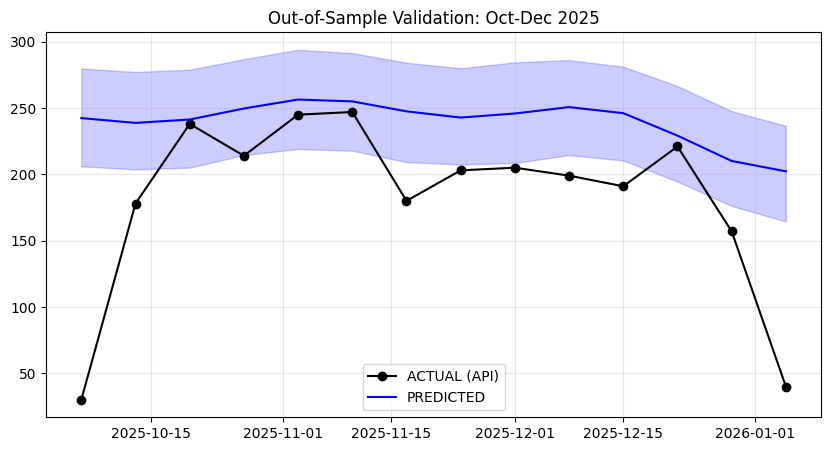

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(results['ds'], results['y'], 'ko-', label='ACTUAL (API)')
plt.plot(results['ds'], results['yhat'], 'b-', label='PREDICTED')
plt.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'], color='blue', alpha=0.2)
plt.title("Out-of-Sample Validation: Oct-Dec 2025")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()